<a href="https://colab.research.google.com/github/meta-llama/llama-recipes/blob/main/recipes/use_cases/agents/langchain/langgraph-agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -U langchain_groq langchain langchain_community sentence_transformers tavily-python tiktoken langchainhub chromadb langgraph

# LangGraph agent with Llama 3

Previously, we showed how to build simple agents with the LangChain [tool calling agent](https://python.langchain.com/docs/modules/agents/agent_types/tool_calling/).

However, we see that this can fail in some cases - e.g., if the LLM is not trained or prompted to use tools reliabily.

LangGraph is a framework from the LangChain team that can be used to implement core [agent](https://www.deeplearning.ai/the-batch/how-agents-can-improve-llm-performance/) [principles](https://lilianweng.github.io/posts/2023-06-23-agent/), including:

- **Planning:** Break down task into smaller subgoals
- **Memory:** Short-term (e.g., chat history) and / or long-term (e.g., vectorstore)
- **Tool use:** Tools (e.g., web search)
- **Multi-agent:** Several agents collaborating

With **LangGraph**: 
- **Planning:** The user will lay out a control flow ahead of time as a graph
- **Memory:** The graph state persists relevant information (e.g., documents, question) across the life of the agent
- **Tool use:** Each graph node performs a specific task that modifies state, which can include tool use

Let's walk through the basic ideas in the [previously shown tool-calling-agent](https://python.langchain.com/docs/modules/agents/agent_types/tool_calling/) using LangGraph.

## Search agent

Let's create a simple agent that can execute web search to supplement the LLM's knowledge.

Let's use [Tavily](https://tavily.com/#api) for web search.

In [ ]:
import os

os.environ['TAVILY_API_KEY'] = 'YOUR_TAVILY_API_KEY'

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults
web_search_tool = TavilySearchResults(k=3)

Let's also use RAG on search results.

We'll use [Groq](https://groq.com/) to access Llama 3 - to get a free Groq API key, sign in with your github or gmail account [here](https://console.groq.com/).

In [ ]:
os.environ['GROQ_API_KEY'] = 'YOUR_GROQ_API_KEY'

In [ ]:
### Generate

from langchain import hub
from langchain_groq import ChatGroq
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")
prompt.pretty_print()

# LLM
llm = ChatGroq(temperature=0, model="llama3-70b-8192")

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Chain
rag_chain = prompt | llm | StrOutputParser()

Here is the simple graph:

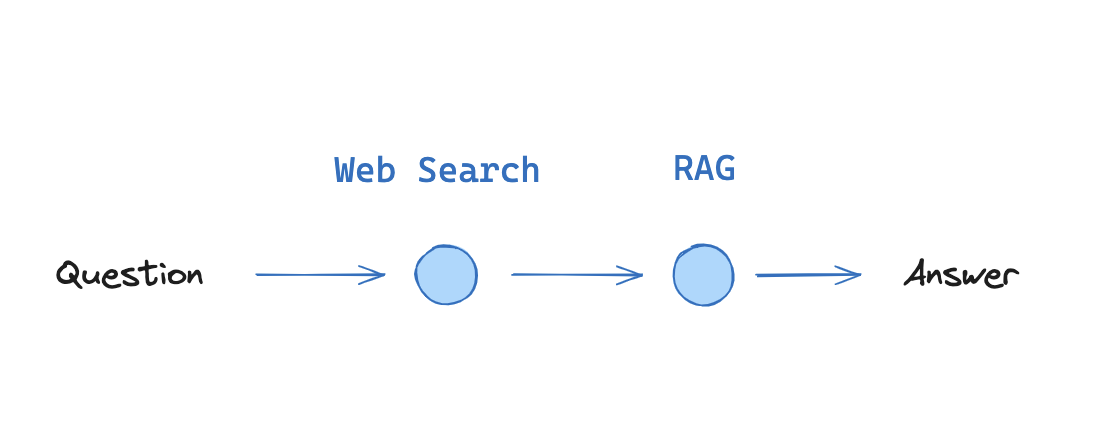

The graph state is our short-term memory.

We'll use it to hold any information that we want our agent to use.

In [ ]:
from typing_extensions import TypedDict
from typing import List

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        answer: answer
        web_search: Tavily web search results
    """
    question : str
    web_search : str
    answer : str

We define a graph nodes that performs web search and RAG.

In [ ]:
def web_search(state):
    """
    Web search based based on the question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended web results to web_search
    """

    print("---WEB SEARCH---")
    question = state["question"]
    docs = web_search_tool.invoke({"query": question})
    web_search = "\n".join([d["content"] for d in docs])
    return {"web_search": web_search, "question": question}

def generate(state):
    """
    Generate answer using RAG on web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, answer, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    web_search = state["web_search"]
    
    # RAG generation
    generation = rag_chain.invoke({"context": web_search, "question": question})
    return {"web_search": web_search, "question": question, "answer": generation}

We define a graph.

In [ ]:
# Register the nodes
from langgraph.graph import END, StateGraph
workflow = StateGraph(GraphState)
workflow.add_node("websearch", web_search) # web search
workflow.add_node("generate", generate) # rag

In [ ]:
# Build graph
workflow.set_entry_point("websearch")
workflow.add_edge("websearch", "generate")
workflow.add_edge("generate", END)

In [ ]:
# Compile and run
app = workflow.compile()
app.invoke({"question":"what is llama3?"})

Let's review

- **Planning:** We laid out the control flow ahead of time with search and RAG
- **Memory:** Use graph state to persist relevant information (e.g., search results, question)
- **Tool use:** We defined a node that invoked the search tool

Here is the trace: 

https://smith.langchain.com/public/1ec212d9-2979-4e6a-af41-c0d7cf39f18b/r

## Search and Retrieval Agent

We can give our LangGraph agent multiple tools.

For example, let's assume we want to perform retrieval and web search.

We'll use retrieval if the question relates to LangSmith.

In [ ]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Retriever
loader = WebBaseLoader("https://docs.smith.langchain.com/overview")
docs = loader.load()
documents = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=200
).split_documents(docs)
vector = Chroma.from_documents(documents, HuggingFaceEmbeddings())
retriever = vector.as_retriever()

We'll need a way to route questions between vectorstore and web search.

In [ ]:
### Router

from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_groq import ChatGroq

# Data model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "web_search"] = Field(
        ...,
        description="Given a user question choose to route it to web search or a vectorstore.",
    )

# LLM with function call 
llm = ChatGroq(temperature=0, model="llama3-70b-8192")
structured_llm_router = llm.with_structured_output(RouteQuery)

# Prompt 
system = """You are an expert at routing a user question to a vectorstore or web search.
The vectorstore contains information related to LangSmith. Use the vectorstore for questions 
that mention LangSmith. Otherwise, use web-search."""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

question_router = route_prompt | structured_llm_router
print(question_router.invoke({"question": "Who will the Bears draft first in the NFL draft?"}))
print(question_router.invoke({"question": "What is LangSmith?"}))

Here is our graph flow.

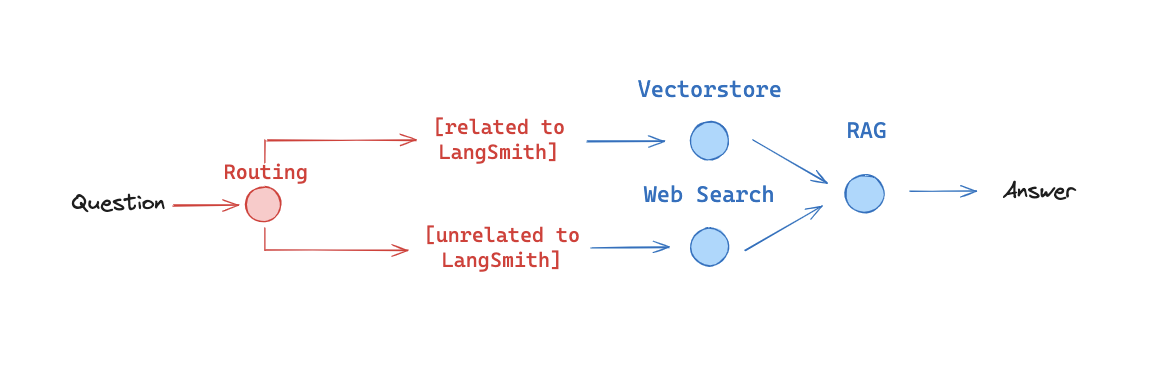

Set state, similar to above.

In [ ]:
from typing_extensions import TypedDict
from typing import List

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        answer: answer
        context: Docs from web search or vectorstore
    """
    question : str
    context : str
    answer : str

Set nodes, similar to above.

In [ ]:
def retrieve(state):
    """
    Web search based based on the question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended web results to web_search
    """

    print("---RETRIEVE---")
    question = state["question"]
    docs = retriever.invoke(question)
    docs_str = "\n".join([d.page_content for d in docs])
    return {"context": docs_str, "question": question}

def web_search(state):
    """
    Web search based based on the question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended web results to web_search
    """

    print("---WEB SEARCH---")
    question = state["question"]
    docs = web_search_tool.invoke({"query": question})
    web_search = "\n".join([d["content"] for d in docs])
    return {"context": web_search, "question": question}

def generate(state):
    """
    Generate answer using RAG on web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, answer, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    context = state["context"]
    
    # RAG generation
    generation = rag_chain.invoke({"context": context, "question": question})
    return {"context": context, "question": question, "answer": generation}

Now, we have one conditional edge. 

The output of this conditerional edge determine the next node to visit.

In [ ]:
### Conditional edge

def route_question(state):
    """
    Route question to web search or vectorstore.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})  
    if source.datasource == 'web_search':
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "websearch"
    elif source.datasource == 'vectorstore':
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

Add nodes

In [ ]:
from langgraph.graph import END, StateGraph
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("websearch", web_search) # web search
workflow.add_node("retrieve", retrieve) # retrieve
workflow.add_node("generate", generate) # generatae

In [ ]:
# Build graph
workflow.set_conditional_entry_point(
    route_question,
    {   # Decision from edge -> Next node to visit
        "websearch": "websearch",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("websearch", "generate")
workflow.add_edge("retrieve", "generate")
workflow.add_edge("generate", END)

# Compile
app = workflow.compile()

In [ ]:
app.invoke({"question":"Who did the Bears draft first in the NFL draft?"})

Trace: 

https://smith.langchain.com/public/16b2ea06-5d2a-451e-b77d-7c5c0baefa04/r

In [ ]:
app.invoke({"question":"how can langsmith help with testing?"})

Trace: 

https://smith.langchain.com/public/54bc2dcf-aab7-49f5-b144-11d87f7ad799/r

### Trace-offs vs Agent Executor

There are trade-offs between LangGraph and Agent Executor for implementing agents.

#### LangGraph

`Pros -`

It is highly reliable.

And it easy to audit.

`Cons -` 

LangGraph requires more code the lay out the same functionality as shown in the first Agent Executor notebook. 

LangGraph is less flexible because the control flow is set by the developer. It can only follow the plan set by the developer.

#### Agent Executor

`Pros -`

Agent Executor is more flexible; the LLM can choose any tool at each step in the agent's reasoning.

It also requires fewer lines to code to implement the same functionality relative to LangGraph.

`Cons -`

But it needs high quality tool-calling, as the LLM is responisibile for making decisions about which tool to use at each step.

Also, it is harder to audit. 

For example, [here](https://smith.langchain.com/public/92c8157d-da30-475b-bfb7-076fd1be4377/r) is the trace of the same workflow as we did above using Agent Executor.

We can see that the agent correctly decides to query the vectorstore for a question about LangSmith. And it appears to get stuck in a loop of calling various tools before crashing.

Of course, this is using a non-fine-tuned (only prompting) version of Llama 3 for tool-use. But it illustates the reliability challenges with using Agent Executor.